In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# This is one CNN we can use for segmentation.
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [2]:
sys.path.insert(
    0, os.path.abspath(os.path.join(os.getcwd(), "../../DermSynth3D_private"))
)

from dermsynth3d.datasets.datasets import (
    SynthDataset,
    FitzDataset,
)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
img_size = (256, 256)

### Prepare the train data

In [5]:
# Assumes the model was pretrained using these values.
preprocess_input = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
img_preprocess = A.Compose(
    [
        preprocess_input,
    ]
)

# To force a resize of the input image.
resize_func = A.Resize(height=img_size[0], width=img_size[1])

# Perform spatial augmentation on both the image and mask.
spatial_augment = A.Compose(
    [
        A.HorizontalFlip(),
        A.RandomRotate90(),
        resize_func,
    ]
)

# Different types of augmentations on the image.
min_v = 0.8
max_v = 1.2
img_augment = A.Compose(
    [
        A.ColorJitter(
            brightness=(min_v, max_v),
            contrast=(min_v, max_v),
            saturation=(min_v, max_v),
            hue=(-0.025, 0.025),
        ),
        A.ISONoise(color_shift=(0.01, 0.1), intensity=(0.1, 0.75), always_apply=False),
        A.GaussianBlur(blur_limit=(3, 3)),
        A.ImageCompression(10, 100),
    ]
)

In [34]:
# Point to the synthetic data you created.
dir_images = "../data/all_data/images"
dir_targets = "../data/all_data/targets"

synth_ds = SynthDataset(
    dir_images=dir_images,
    dir_targets=dir_targets,
    name="synth_train",
    spatial_transform=spatial_augment,
    image_augment=img_augment,
    image_preprocess=preprocess_input,
    target_preprocess=None,
    target_extension=".npz",
    totensor=ToTensorV2(transpose_mask=True),
)

### Sanity check the images before and after augmentation.

In [35]:
file_id = synth_ds.file_ids[1]
file_id

'832eca550437438bb9abcb0fee975dea'

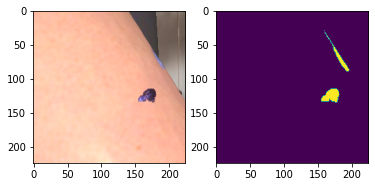

In [36]:
plt.subplot(1, 2, 1)
img = synth_ds.image(file_id)
plt.imshow(img)
plt.subplot(1, 2, 2)
target = synth_ds.target(file_id)
plt.imshow(target[:, :, 0])

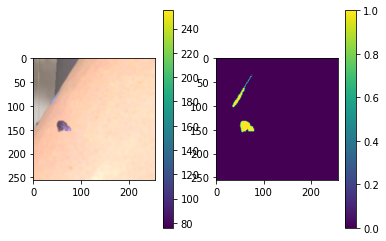

In [37]:
# Apply the same spatial transform to both the image and mask.
spatial = synth_ds.spatial_transform(image=np.asarray(img), mask=target)

# Augment only the image.
augmented_image = synth_ds.image_augment(image=spatial["image"])

# This will give you a sense of what the augmentations
# should look like.
# plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(augmented_image["image"])
plt.colorbar()  # plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(spatial["mask"][:, :, 0])
plt.colorbar()  # plt.axis('off')

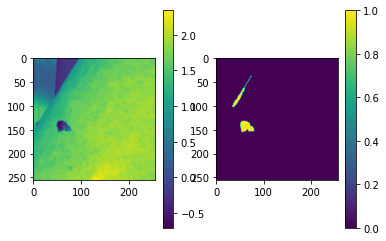

In [38]:
# After preprocessing.
preprocess_image = img_preprocess(image=augmented_image["image"])
# Convert to tensors.
tensors = synth_ds.totensor(image=preprocess_image["image"], mask=spatial["mask"])
plt.subplot(1, 2, 1)
plt.imshow(tensors["image"][1, :, :])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(tensors["mask"][0, :, :])
plt.colorbar()

### Train Segmentation Model

In [ ]:
# DataLoader for training the CNN.
batch_size = 8
train_dataloader = DataLoader(
    synth_ds, batch_size=batch_size, shuffle=True, drop_last=True
)

In [42]:
seg_model = deeplabv3_resnet50(pretrained=True)
n_classes = 1
seg_model.classifier = DeepLabHead(2048, n_classes)

In [44]:
seg_model = seg_model.to(device)
seg_model.train();

In [46]:
optimizer = torch.optim.Adam(seg_model.parameters(), lr=0.00005, weight_decay=1e-5)

In [47]:
sigmoid = torch.nn.Sigmoid()
criterion = torch.nn.BCELoss()

In [48]:
train_losses = []
step_idx = 0
num_epochs = 50

In [50]:
min_loss = 1.0
SAVE_DIR = "/path/to/save/model"
for epoch in range(num_epochs):
    seg_model.train()
    for dataset_types, image_ids, images, segs in train_dataloader:
        optimizer.zero_grad()

        images = images.to(device)
        segs = segs.to(device)
        out = seg_model(images)
        preds = sigmoid(out["out"])
        loss = criterion(preds, segs)

        if loss < 0:
            raise ValueError("Negative loss")

        train_losses.append([step_idx, loss.item()])
        step_idx += 1
        loss.backward()
        optimizer.step()

    print("epoch={}, step={}, loss={}".format(epoch, step_idx, loss.item()))

PATH = SAVE_DIR + "epoch" + str(epoch) + ".pt"
torch.save(seg_model.state_dict(), PATH)

epoch=0, step=24, loss=0.3924947679042816
epoch=1, step=36, loss=0.3758513927459717
epoch=2, step=48, loss=0.2892465591430664
epoch=3, step=60, loss=0.38167518377304077
epoch=4, step=72, loss=0.2283087968826294
epoch=5, step=84, loss=0.26719698309898376
epoch=6, step=96, loss=0.3163485527038574
epoch=7, step=108, loss=0.2868897020816803
epoch=8, step=120, loss=0.1779196858406067
epoch=9, step=132, loss=0.18689362704753876
epoch=10, step=144, loss=0.11335530877113342
epoch=11, step=156, loss=0.19376009702682495
epoch=12, step=168, loss=0.17559592425823212
epoch=13, step=180, loss=0.1425989270210266
epoch=14, step=192, loss=0.1111968606710434
epoch=15, step=204, loss=0.2647216320037842
epoch=16, step=216, loss=0.15978634357452393
epoch=17, step=228, loss=0.19342327117919922
epoch=18, step=240, loss=0.1954575479030609
epoch=19, step=252, loss=0.12705370783805847
epoch=20, step=264, loss=0.2022818773984909
epoch=21, step=276, loss=0.08962570875883102
epoch=22, step=288, loss=0.172807544469

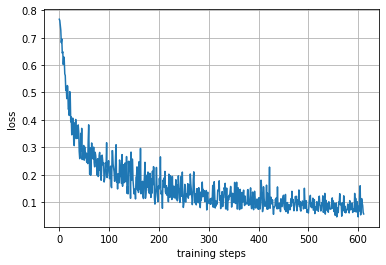

In [51]:
# Show the loss over the training data.
train_losses_np = np.asarray(train_losses)
plt.plot(train_losses_np[:, 0], train_losses_np[:, 1])
plt.xlabel("training steps")
plt.ylabel("loss")
plt.grid()

In [52]:
# Sanity check where we check the model over the TRAINING data.
seg_model.eval()
with torch.no_grad():
    for _, file_ids, images, segs in train_dataloader:
        images = images.to(device)
        segs = segs.to(device)
        out = seg_model(images)
        seg_predicted = sigmoid(out["out"])
        break

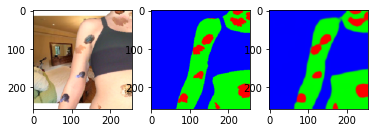

In [53]:
# The predicted should pretty well match the true.
# Note the image itelf might be a bit different since
# the image is without the spatial transform.
idx = 0
img = synth_ds.image(file_ids[idx], img_size=img_size)
# img = transforms.ToPILImage()(images[idx])
plt.subplot(1, 3, 1)
plt.imshow(img)
seg_pil = transforms.ToPILImage()(segs[idx][:3, :, :])
plt.subplot(1, 3, 2)
plt.imshow(seg_pil)
pred_pil = transforms.ToPILImage()(seg_predicted[idx])
plt.subplot(1, 3, 3)
plt.imshow(pred_pil)